In [1]:
import torch
from matplotlib import pyplot as plot
from torch.nn import functional as F

In [2]:
with open("names.txt", "r") as f:
    names = [_.strip() for _ in f.readlines()]

names[0:5], len(names)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

In [3]:
chars = list(set("".join(names)))
chars.insert(0, ".")
chars

['.',
 't',
 'w',
 'y',
 'h',
 'b',
 'q',
 'z',
 'g',
 'l',
 'r',
 'c',
 'm',
 'n',
 'u',
 'e',
 'i',
 'v',
 'p',
 'j',
 'o',
 'd',
 'x',
 'a',
 'k',
 's',
 'f']

In [4]:
ctoi = { c:i for i, c in enumerate(chars)}
itoc = { i:c for i, c in enumerate(chars)}

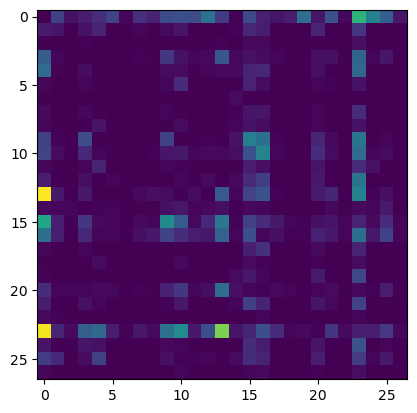

In [68]:
N = torch.zeros((27, 27), dtype=torch.int) # N is count vector

for x in names:
    x = "." + x + "."
    for c1, c2 in zip(x, x[1:]):
        c1i = ctoi[c1]
        c2i = ctoi[c2]
        N[c1i, c2i] += 1
        
plot.imshow(N)

In [69]:
P = N / N.sum(dim=1, keepdims=True)
P[5,:].sum()

tensor(1.)

In [70]:
bigrams = []
for x in names:
    x = "." + x + "."
    for c1, c2 in zip(x, x[1:]):
        bigrams.append((c1, c2))

In [71]:
logp = 0;
for c1, c2 in bigrams:
    c1 = ctoi[c1]
    c2 = ctoi[c2]
    logp += P[c1, c2].log().item()

nll = -logp / len(bigrams)
nll

2.454014497322693

In [73]:
gen = torch.Generator()
gen.manual_seed(2147483647)

for _ in range(10):
    sample = "."
    while(True):
        c1 = sample[-1]
        i1 = ctoi[c1]
        i2 = torch.multinomial(P[i1], 1, generator=gen).item()
        sample += itoc[i2]

        if i2 == 0:
            break
    
    print(sample)

.h.
.kwn.
.menicariley.
.coshanin.
.lyronalan.
.caha.
.ce.
.da.
.jan.
.siderariyn.


## Bigram Neural Net

In [74]:
def create_bigram_ds(names): 
    x = []
    y = []
    for s in names:
        s = "." + s + "."
        for c1, c2 in zip(s, s[1:]):
            x.append(ctoi[c1])
            y.append(ctoi[c2])
    
    x = F.one_hot(torch.tensor(x), num_classes=27).float()
    y = torch.tensor(y)
    
    return x, y
    
x, y = create_bigram_ds(names)
x.shape

torch.Size([228146, 27])

In [11]:
train, dev, test = torch.utils.data.random_split(names, [0.8, 0.1, 0.1])
len(train), len(dev), len(test)

(25627, 3203, 3203)

In [12]:
train_ds = create_bigram_ds(train)
dev_ds = create_bigram_ds(dev)
test_ds = create_bigram_ds(test)

In [125]:
def cal_loss(W, dataset, decay=0):
    with torch.no_grad():
        X, ys = dataset
        logits = X @ W
        loss = F.cross_entropy(logits, ys)
    
    return loss

In [133]:
def fits(W, train_ds, dev_ds, epoch, decay=0, verbose=True):
    X, ys = train_ds
    n = X.shape[0]
    print_ev = epoch / 10
    
    for i in range(epoch):
        W.grad = None
        logits = X @ W
        
        # counts = logits.exp()
        # probs = counts / counts.sum(1, keepdims=True)
        # loss = -probs[torch.arange(n), ys].log().mean() + decay*(W**2).mean()
        
        loss = F.cross_entropy(logits, ys) + decay*(W**2).mean()
        loss.backward()

        if i % print_ev == 0 and verbose:
            dev_loss = cal_loss(W, dev_ds)
            print(f"train: {loss.item():.4f}  dev: {dev_loss:.4f}")

        W.data -= 10 * W.grad

In [153]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27, 27, requires_grad=True, generator=g)
fits(W, train_ds, dev_ds, 100)
print("----")
print(f"test: {cal_loss(W, test_ds)}")

train: 3.6411  dev: 3.6535
train: 3.1051  dev: 3.1184
train: 2.8729  dev: 2.8870
train: 2.7548  dev: 2.7695
train: 2.6884  dev: 2.7034
train: 2.6469  dev: 2.6618
train: 2.6181  dev: 2.6329
train: 2.5968  dev: 2.6114
train: 2.5803  dev: 2.5945
train: 2.5670  dev: 2.5810
----
test: 2.562330961227417


In [92]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27, 27, requires_grad=True, generator=g)
fits(W, train_ds, dev_ds, 100, 0.05)
print("----")
print(f"test: {cal_loss(W, test_ds)}")

train: 3.6894  dev: 3.6535
train: 3.1430  dev: 3.1142
train: 2.9103  dev: 2.8835
train: 2.7939  dev: 2.7671
train: 2.7293  dev: 2.7018
train: 2.6892  dev: 2.6608
train: 2.6619  dev: 2.6324
train: 2.6418  dev: 2.6114
train: 2.6265  dev: 2.5950
train: 2.6144  dev: 2.5820
----
test: 2.564791679382324


In [94]:
g = torch.Generator().manual_seed(2147483647)

def sample_bi(W):
    res = "."
    with torch.no_grad():
        while(True):
            c = res[-1]
            x = torch.tensor(ctoi[c])
            x = F.one_hot(x, num_classes=27).reshape(1, 27).float()

            logits = x @ W
            counts = logits.exp()
            probs = counts / counts.sum(dim=1, keepdims=True)
            ix = torch.multinomial(probs, 1, generator=g).item()
            c2 = itoc[ix]

            res += c2
            if c2 == ".":
                break;

        return res

for _ in range(10):
    print(sample_bi(W))

.h.
.kfn.
.menicdecanifcosganin.
.lyronalan.
.cahcfce.
.da.
.jankoiderariynzeoni.
.leflevackeriaionh.
.anconnan.
.johzd.


# Trigram Neural Net

In [90]:
def create_tri_ds(names): 
    x1 = []
    x2 = []
    y = []
    for s in names:
        s = ".." + s + ".."
        for c1, c2, c3 in zip(s, s[1:], s[2:]):
            x1.append(ctoi[c1])
            x2.append(ctoi[c2])             
            y.append(ctoi[c3])            
                                          
    x1 = F.one_hot(torch.tensor(x1), num_classes=27).float()
    x2 = F.one_hot(torch.tensor(x2), num_classes=27).float()
    x = torch.cat([x1, x2], dim=1) # (num_data, 2 * char_num)
    y = torch.tensor(y)
    return x, y
    
x, y = create_tri_ds(train)
x.shape

torch.Size([208150, 54])

In [18]:
train_tds = create_tri_ds(train)
dev_tds = create_tri_ds(dev)
test_tds = create_tri_ds(test)

In [150]:
g = torch.Generator().manual_seed(2147483647)
print("decay: 0")
print("----")
W = torch.randn(2 * 27, 27, requires_grad=True, generator=g)
fits(W, train_tds, dev_tds, 100)
print("----")
print(f"test: {cal_loss(W, test_tds)}")

decay: 0
----
train: 4.1165  dev: 4.1235
train: 2.8635  dev: 2.8786
train: 2.5490  dev: 2.5650
train: 2.4113  dev: 2.4271
train: 2.3368  dev: 2.3523
train: 2.2895  dev: 2.3048
train: 2.2561  dev: 2.2713
train: 2.2311  dev: 2.2461
train: 2.2116  dev: 2.2264
train: 2.1960  dev: 2.2106
----
test: 2.1861460208892822


In [149]:
g = torch.Generator().manual_seed(2147483647)
print("decay: 0.01")
print("----")
W = torch.randn(2 * 27, 27, requires_grad=True, generator=g)
fits(W, train_tds, dev_tds, 100, 0.1)
print("----")
print(f"test: {cal_loss(W, test_tds)}")

decay: 0.01
----
train: 4.2135  dev: 4.1235
train: 2.9386  dev: 2.8696
train: 2.6187  dev: 2.5555
train: 2.4787  dev: 2.4181
train: 2.4025  dev: 2.3436
train: 2.3539  dev: 2.2964
train: 2.3195  dev: 2.2631
train: 2.2937  dev: 2.2383
train: 2.2736  dev: 2.2190
train: 2.2574  dev: 2.2037
----
test: 2.1805543899536133


In [145]:
def param_expr(decay, epoch):
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn(2 * 27, 27, requires_grad=True, generator=g)
    fits(W, train_tds, dev_tds, epoch, decay, verbose=False)
    loss = cal_loss(W, test_tds)
    print(f"decay: {decay:.4f}  test: {loss:.4f}")

In [146]:
epoch = 200
param_expr(0, epoch)
param_expr(0.01, epoch)
param_expr(0.05, epoch)
param_expr(0.1, epoch)

decay: 0.0000  test: 2.1227
decay: 0.0100  test: 2.1222
decay: 0.0500  test: 2.1213
decay: 0.1000  test: 2.1220


In [147]:
epoch = 800
param_expr(0, epoch)
param_expr(0.01, epoch)
param_expr(0.05, epoch)
param_expr(0.1, epoch)

decay: 0.0000  test: 2.0665
decay: 0.0100  test: 2.0674
decay: 0.0500  test: 2.0733
decay: 0.1000  test: 2.0831


In [99]:
def sample_tri(W):
    # rdn_ix = torch.randint(1, 26, (1, )).item()
    sample = ".."
    while(True):
        c1 = sample[-2]
        c2 = sample[-1]
        x1 = F.one_hot(torch.tensor([ctoi[c1]]), num_classes=27).float()
        x2 = F.one_hot(torch.tensor([ctoi[c2]]), num_classes=27).float()
        x = torch.cat([x1, x2], dim=1)

        logits = x @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdims=True)
        ix = torch.multinomial(probs, 1, generator=gen).item()
        c3 = itoc[ix]

        sample += c3
        if c3 == ".":
            break;
            
    return sample

for _ in range(10):
    print(sample_tri(W))

..ariyah.
..draniearasamx.
..jumadxjlf.
..tea.
..wadlin.
..fbzesen.
..sae.
..cia.
..na.
..eon.


# Cross Entropy vs Manual Calculation

In [236]:
def init_data():
    g = torch.Generator().manual_seed(2147483647)
    n = 100
    feature_size = 100

    W = torch.randn(feature_size, feature_size, requires_grad=True, generator=g)
    X = torch.randn(n, feature_size, requires_grad=True, generator=g)
    y = torch.randint(0, feature_size-1, (n,), generator=g)    
    
    return X, W, y

Manual calculation

In [279]:
%time
X, W, y = init_data()

logits = X@W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(y.shape[0]), y].log().mean()
loss

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 12.9 µs


tensor(23.7999, grad_fn=<NegBackward0>)

Using `F.cross_entropy`

In [280]:
%time
X, W, y = init_data()

logits = X@W
loss = F.cross_entropy(logits, y)
loss

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 15 µs


tensor(23.7999, grad_fn=<NllLossBackward0>)

# Exercise Answer

1. Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

    > Trigram model seem to yield better loss

2. Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
    
    
3. use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?
    
    
    > When training with 800 epoch, I yield an unexpected test loss pattern. 
    > ```
        decay: 0.0000  test: 2.0665
        decay: 0.0100  test: 2.0674
        decay: 0.0500  test: 2.0733
        decay: 0.1000  test: 2.0831
    > ```  
    > I expected regularization should help improve test loss, but from the experiments, no regularization seems to yield best test loss


    
    
4. We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

1. Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?